In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pymongo import MongoClient
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import pymysql
import seaborn as sns
import datetime
# CNN
from keras.layers.convolutional import Conv1D
# RNN
from keras.layers.recurrent import LSTM

In [2]:
maxlen = 500
max_words=200
n_epochs = 6
n_df_size = 30000
model_name_for_sql = 'selfnn'
tosql = False

In [3]:
agg = [
    {
        '$sample': {
            'size': n_df_size
        }
    }
]

In [4]:
client = MongoClient("localhost:27017")
db=client.indv
result=db.labeled.aggregate(agg)
source=list(result)
df=pd.DataFrame(source)
df.head()

,_id,level_0,index,Unnamed: 0,Review,Label,Total_Words
0,5ff492e4e042fba49721d1dc,291600,291600,291600,The towels smelled and its more of a self ser...,Negative,19
1,5ff492e5e042fba497231503,676964,676964,676964,I ordered 2 yogurts and 2 pineapple juices fr...,Positive,46
2,5ff492e0e042fba4971b04af,164877,164877,164877,Mix up with booking on arrival I noticed the ...,Negative,49
3,5ff492e1e042fba4971c1004,648502,648502,648502,Great location clean room nice breakfast buffet,Positive,7
4,5ff492e6e042fba49724a111,290420,290420,290420,Rooms facing to main street were noisy,Negative,7


In [5]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(df['Review'])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df['Label']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

<AxesSubplot:xlabel='Label', ylabel='count'>

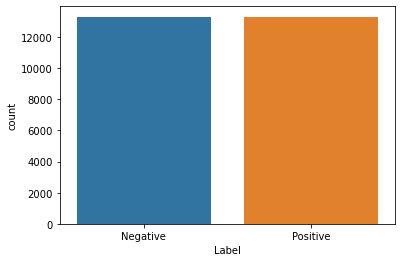

In [6]:
g = df.groupby('Label')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df = g
sns.countplot(x='Label', data=df)

In [ ]:
df.shape

In [7]:
# Convelutional ///////////

# create the model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=maxlen))
    #  text is 1 dimensional, so Conv1D
    #  the kernel in this case is a vector of length 5, not a 2 dimensional matrix
model.add(Conv1D(128, 5, activation='relu'))
    #  the pooling layer in this case is also 1 dimensional
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           436608    
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 128)          20608     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 457,345
Trainable params: 457,345
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
history=model.fit(X_train, y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])

Epoch 1/6
150/150 [==============================] - 49s 327ms/step - loss: 0.3976 - accuracy: 0.8206 - val_loss: 0.2281 - val_accuracy: 0.9121
Epoch 2/6
150/150 [==============================] - 43s 286ms/step - loss: 0.2211 - accuracy: 0.9136 - val_loss: 0.2196 - val_accuracy: 0.9158
Epoch 3/6
150/150 [==============================] - 44s 293ms/step - loss: 0.2103 - accuracy: 0.9196 - val_loss: 0.2131 - val_accuracy: 0.9175
Epoch 4/6
150/150 [==============================] - 45s 300ms/step - loss: 0.2021 - accuracy: 0.9244 - val_loss: 0.2109 - val_accuracy: 0.9204
Epoch 5/6
150/150 [==============================] - 45s 303ms/step - loss: 0.1949 - accuracy: 0.9267 - val_loss: 0.2097 - val_accuracy: 0.9196
Epoch 6/6
188/188 [==============================] - 6s 34ms/step - loss: 0.2185 - accuracy: 0.9118
Test Score: 0.2185387760400772
Test Accuracy: 0.9118333458900452
